In [185]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt 
import pickle 
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind,  shapiro, mannwhitneyu, pearsonr
import seaborn as sb

N_episode = 300
FIGSIZE = (16,9)
colors = ['crimson', 'royalblue', 'darkgreen', 'orange', 'blueviolet']
LW = 5

In [188]:
def plot_performance(data, X=None, names=None, title="", ylabel="performance", 
                     minimum = -np.inf, maximum=np.inf, log=False, double=False, xlabel="learning episodes"):
    """
    data = [n_param, n_run, episode_length]
    """
    
    if names is None:
        names = [str(j) for j in range(len(data))]
    compute_X = (X is None)
    if len(data)<6:
        ncol = [1,1,2,2,3][len(data)-1] 
    else:
        ncol = len(data)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    handles = []
    for i in range(len(data)):
        if (double and i>=len(data)/2):
            linestyle = ":"
            color = colors[i%(len(data)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.mean(data[i], axis=0), np.std(data[i], axis=0)
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]

        for run in range(len(data[i])):
            plt.plot(X, data[i][run], color=color, lw=2, alpha=0.3, linestyle=linestyle)
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
       # ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
       # plt.plot(X, mean_p_std, color=color, alpha=0.2)
        #plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        if (X[1]-X[0])!=(X[-1]-X[-2]):
            plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2,ncol=1,bbox_to_anchor=(1.01, 1.))
    plt.show()

In [132]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

def compute_test(data, coef=1, N=5):
    pairs = []
    for i in range(N-1):
        for j in range(i+1,N):
            pairs.append((i,j))
    res = [[] for _ in range(N)]
    cells = [[ '' for _ in range(N-1)] for _ in range(N-1)]
    for (param1,param2) in pairs:
        data1 = np.array(data[param1])
        data2 = np.array(data[param2])
        stat, p_t = ttest_ind(data1,data2)
        p_t = p_t*coef
        d = truncate( np.mean(data1)-np.mean(data2), 2)
        if d=='0.00' or d=='-0.00':
            d = truncate( np.mean(data1)-np.mean(data2), 3)
            if d=='0.000' or d=='-0.000':
                d = truncate( np.mean(data1)-np.mean(data2), 4)
        if p_t < 0.001:
            res.append((param1, param2, '***'))
            cells[param1][N-1-param2] = d+'\n***'
        elif p_t < 0.01:
            res.append((param1, param2, '**'))
            cells[param1][N-1-param2] = d+'\n**'
        elif p_t < 0.05:
            res.append((param1, param2, '*'))
            cells[param1][N-1-param2] = d+'\n*'
        else:
            cells[param1][N-1-param2] = "ns"
    return res,cells

def plot_boxplot(data, names, ylabel="performance", ylim=None, title=""):
    N = len(data)
    stat,cells = compute_test(data, 3*N*(N-1)/2, N)
    
    plt.subplots(figsize=(12,10))
    
    bplot = sb.boxplot(data=data)
    for i in range(N):
        bplot.artists[i].set_facecolor(colors[i])
    sb.swarmplot( data=data, color='black', edgecolor='black',size=7)
    
    rows = names[:N-1]
    columns = [names[i] for i in range(N-1,0,-1)]
    cell_text = cells
    cellColours = [['white' if N-1-i>j else 'lightgrey' for j in range(N-1)] for i in range(N-1) ]
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          cellColours= cellColours,
                          rowColours=colors[:N-1],
                          colColours=[ colors[i] for i in range(N-1,0,-1)],
                          colLabels=columns,
                          cellLoc = 'center',
                          bbox=(1.13,0.1,0.5,0.9))
    
    plt.xticks(range(N), names)
    if not ylim is None:
        plt.ylim(ylim)
    plt.ylabel(ylabel)
    plt.title(title)
        
def plot_last_x_rewards(subdirs, names, episodes=100):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations'][0]
            if min_length > len(obs):
                min_length = len(obs)
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations'][0][min_length-episodes:min_length]
            on_legs = [o[:, 30]>0.13 for o in obs]
            reward = []
            for i in range(len(on_legs)):
                j = 0
                while (j < len(obs[i])-1) and on_legs[i][j]:
                    j+=1
                reward.append(obs[i][j][28])
            rewards.append(np.mean(reward))
        Rewards.append(list(rewards))
    title = "Farther point reached on legs on the last "+ str(episodes)+ " episodes"
    plot_boxplot(Rewards, names, ylim=[0,5], ylabel="Average distance reached", title=title)

def plot_z_rewards(subdirs, names, episodes=100):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations'][0]
            rewards.append(np.array([o[-1, 30]<0.13 for o in obs]))
            if min_length > len(obs):
                min_length = len(obs)
        rewards = np.sum([reward[min_length-episodes:min_length]/(episodes) for reward in rewards], axis=1)
        Rewards.append(list(rewards))
    title="Average Percentage of fall of the last "+ str(episodes)+ " episodes"
    plot_boxplot(Rewards, names, ylim=[0,1], ylabel="Percentage of fall", title=title)

In [192]:
def plot_rewards(subdirs, names):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            reward = data['reward_sum'][0][:N_episode]
            rewards.append(reward)
            if min_length > len(reward):
                min_length = len(reward)
        rewards = [ reward[:min_length] for reward in rewards]
        Rewards.append(np.copy(rewards))
    plot_performance(Rewards, names=names)
    
def plot_x_rewards_along(subdirs, names):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations'][0]
            rewards.append([o[-1, 28] for o in obs])
            if min_length > len(obs):
                min_length = len(obs)
        rewards = [ reward[:min_length] for reward in rewards]
        Rewards.append(np.copy(rewards))
    plot_performance(Rewards, names=names)
    
    
def plot_mean_observations(subdirs, names, p):
    Data = []
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            data = data['observations']
            obs.append(np.mean(data[:, :, p], axis=1))
            if min_length > len(data):
                min_length = len(data)
        obs = [ data[100:min_length] for data in obs]
        Data.append(obs)
    plot_performance(Data, names=names)

def plot_actions(subdirs, names):
    Actions = []
    for param in subdirs:
        actions = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            action = data['actions'][:N_episode]
            actions.append(np.mean(np.linalg.norm(action, axis=2), axis=1))
            if min_length > len(action):
                min_length = len(action)
        actions = [ action[:min_length] for action in actions]
        Actions.append(np.copy(actions))
    plot_performance(Actions, names=names)
    
def plot_model_eval(subdirs, names):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['model_eval'][0]
            rewards.append(obs)
            if min_length > len(obs):
                min_length = len(obs)
        rewards = [ reward[:min_length] for reward in rewards]
        Rewards.append(np.copy(rewards))
    plot_performance(Rewards, names=names)
    
def plot_error(subdirs, names):
    Errors = []
    for param in subdirs:
        errors = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            error = data['model_error'][0]
            errors.append(error)
            if min_length > len(error):
                min_length = len(error)
        errors = [ error[:min_length] for error in errors]
        Errors.append(np.copy(errors))
    plot_performance(Errors, names=names)

def plot_model_training(subdirs, names):
    Train, Test = [], []
    for param in subdirs:
        trains, tests = [], []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            test = data['model_error'][0]
            train = data['model_eval'][:, 1]
            trains.append(train)
            tests.append(test)
            if min_length > len(test):
                min_length = len(test)
        tests = [ test[:min_length] for test in tests]
        ttrains = [ train[:min_length] for train in trains]
        Test.append(np.copy(tests))
        Train.append(np.copy(trains))
    Data = Train + Test
    Names = []
    for x in names:
        Names.append("Training error "+x)
        Names.append("Testing error "+x)
    plot_performance(Data, names=Names, double=True, log=True, ylabel="Error", title="One Step Prediction Error")

In [248]:
path = "./exp/log/Saved/GymMinitaur/"

# 4/09
test = ['2019-10-03--16:50:1996067']
random100 = ['2019-10-04--09:49:4680492']
fulleval = ['2019-10-04--11:33:0575608']

accurate = ["2019-10-04--13:55:1845710"]
subdirs1 = [
            [path + x + '/logs.mat' for x in fulleval]*3, 
            [path + x + '/logs.mat' for x in accurate]*3, 
]

names1 = ['1k', '4k', '8k', '16k']

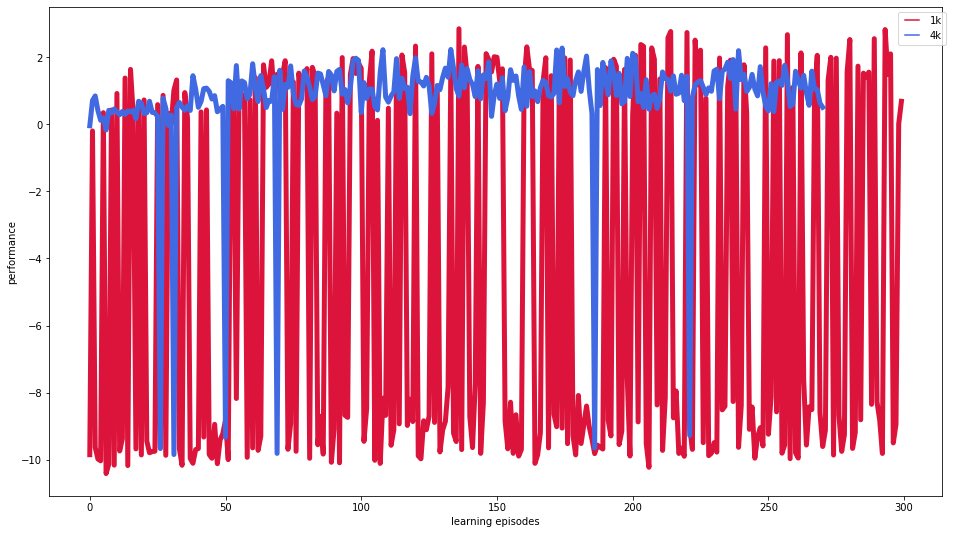

In [262]:
plot_rewards(subdirs1, names1)

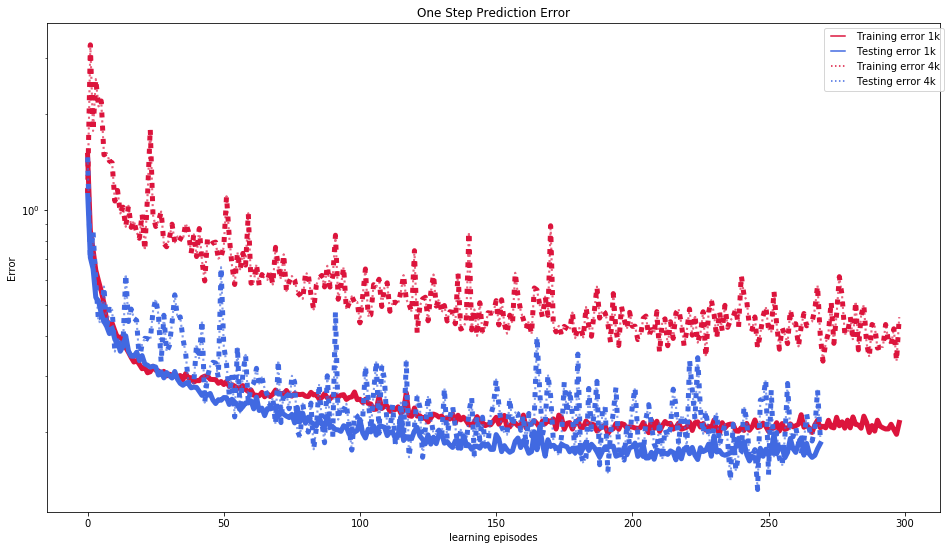

In [263]:
plot_model_training(subdirs1, names1)

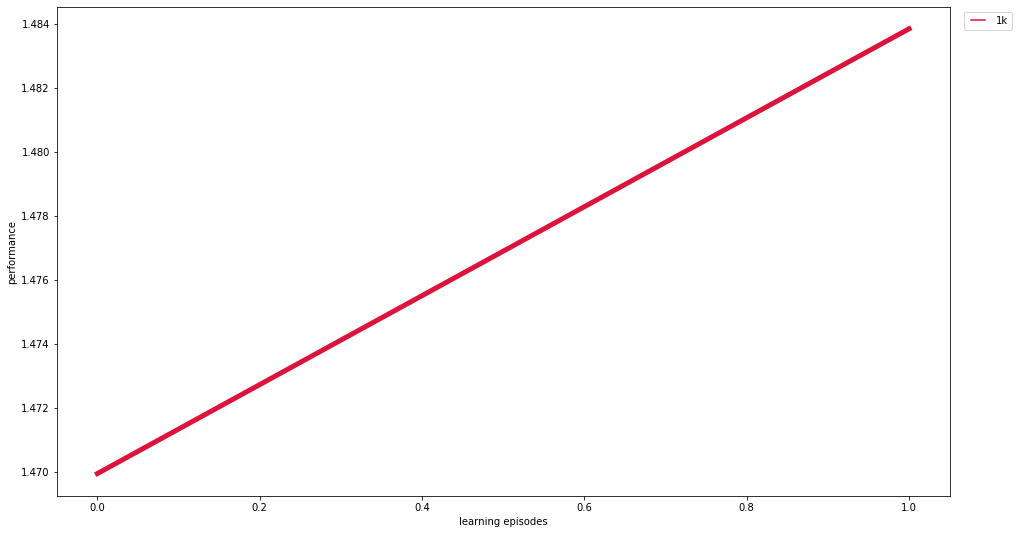

In [238]:
plot_model_eval(subdirs1, names1)

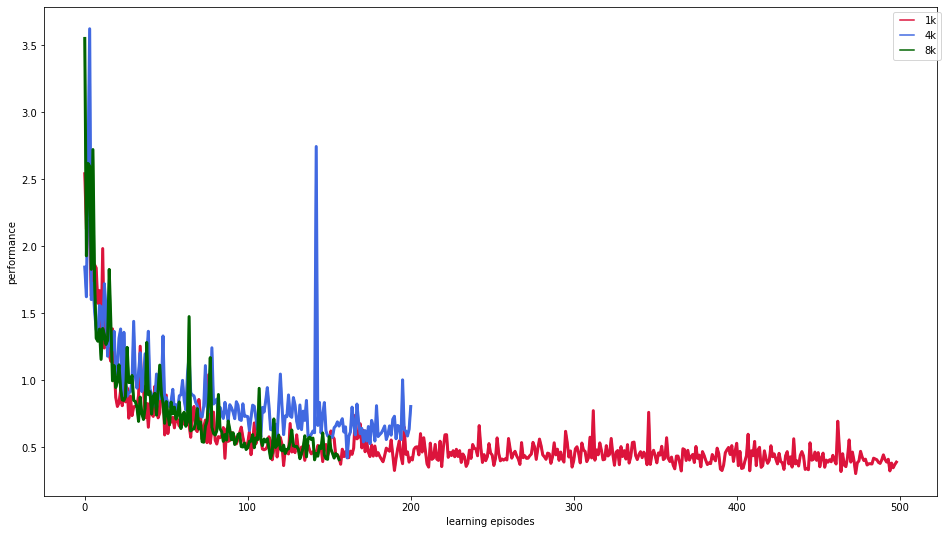

In [138]:
plot_error(subdirs1, names1)

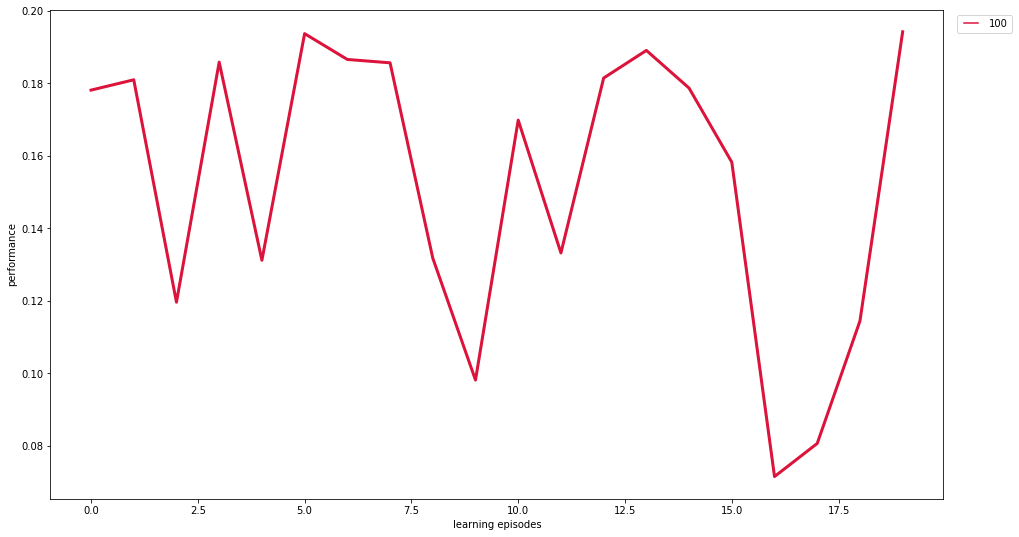

In [87]:
plot_mean_observations(test, names4, 30)

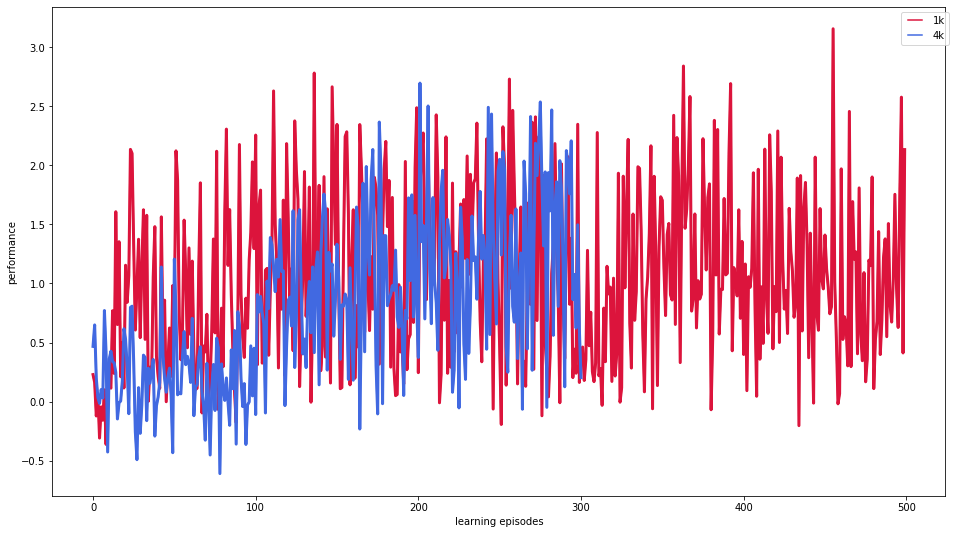

In [111]:
plot_x_rewards_along(subdirs1, names1)

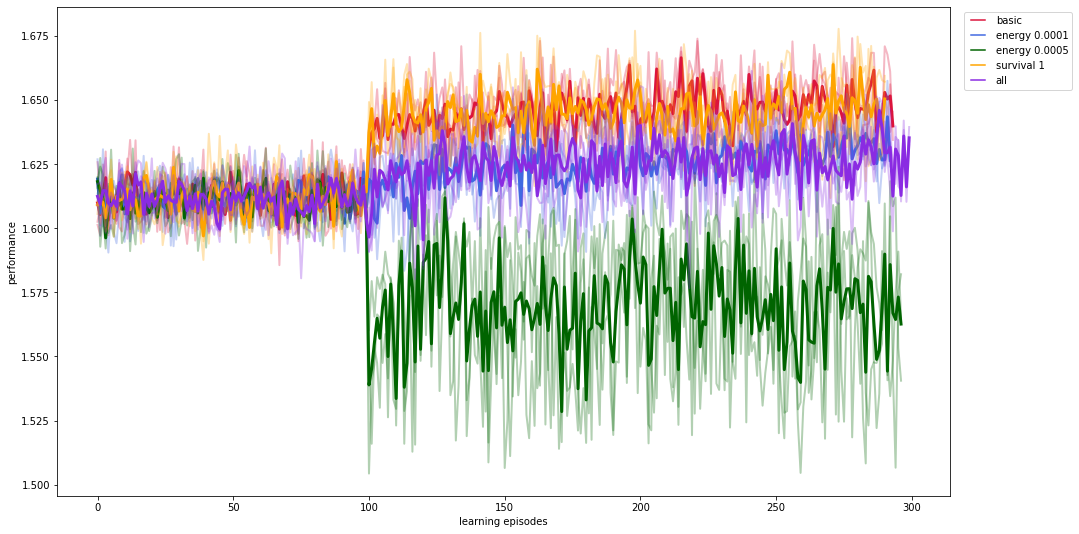

In [392]:
plot_actions(subdirs1, names1)

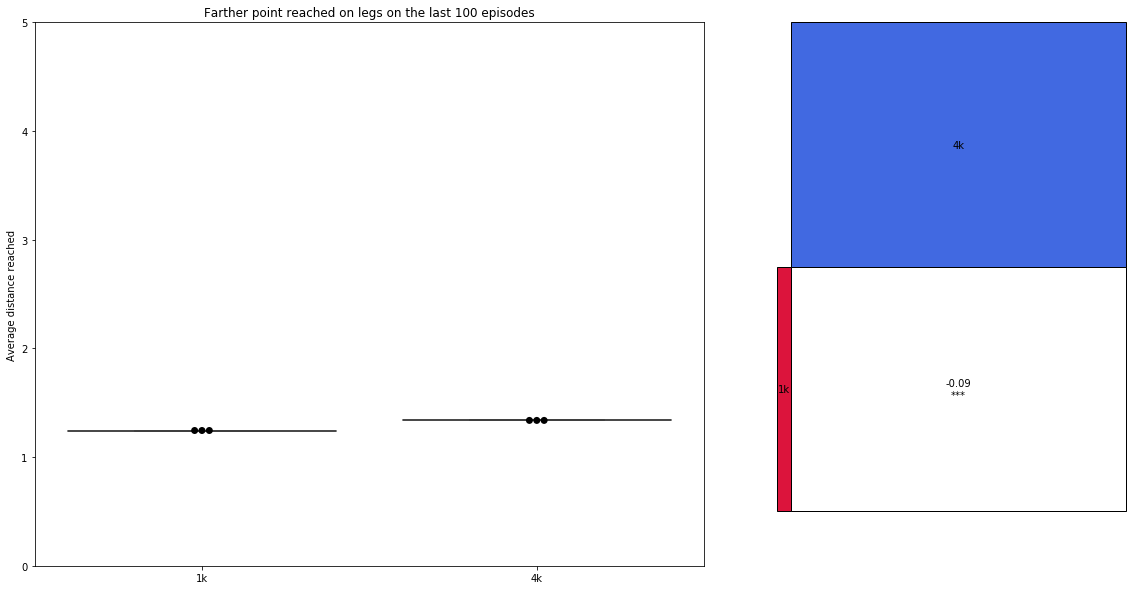

In [251]:
plot_last_x_rewards(subdirs1, names1, 100)

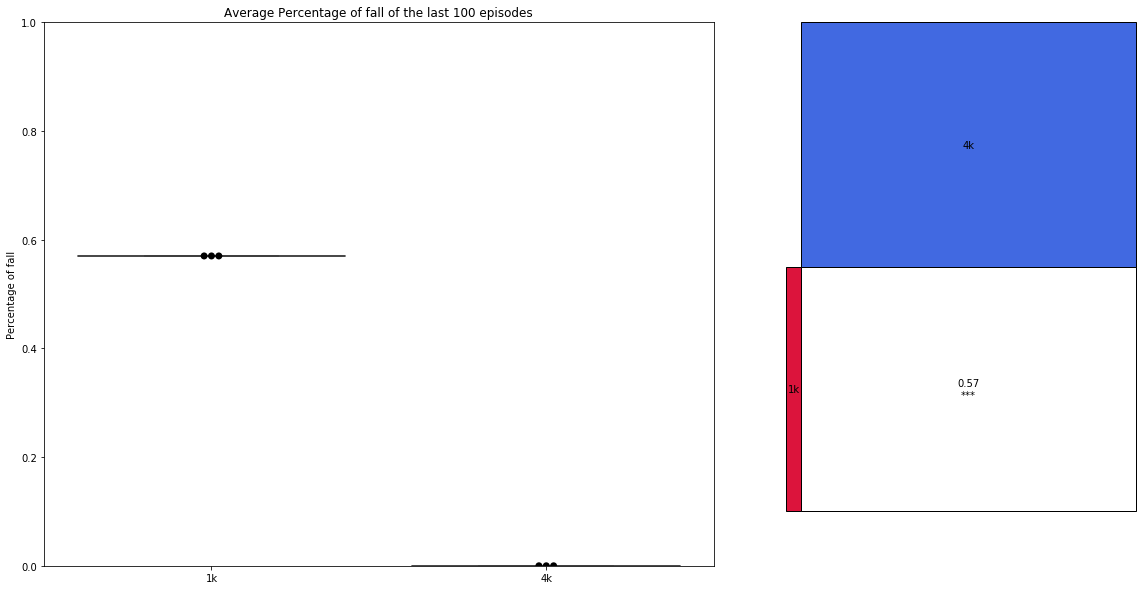

In [254]:
plot_z_rewards(subdirs1, names1, 100)

In [287]:
folder = subdirs1[1][0]
data = scipy.io.loadmat(folder)
controller_params = data['controller_sol'][0]

In [288]:
reward = data['reward_sum'][0]

In [283]:
mini, maxi = np.min(reward), np.max(reward)

In [292]:
def rewardToColor(r):
    if r < -5:
        return 'crimson', 1, 3
    elif r < 0:
        return 'orange', 0.2, 1
    elif r <1 : 
        return 'darkgreen', 0.2, 1
    elif r < 2:
        return 'royalblue',0.3,2
    else:
        return 'blueviolet', 1, 3

/home/timothee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/home/timothee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(-3.141592653589793, 3.141592653589793)

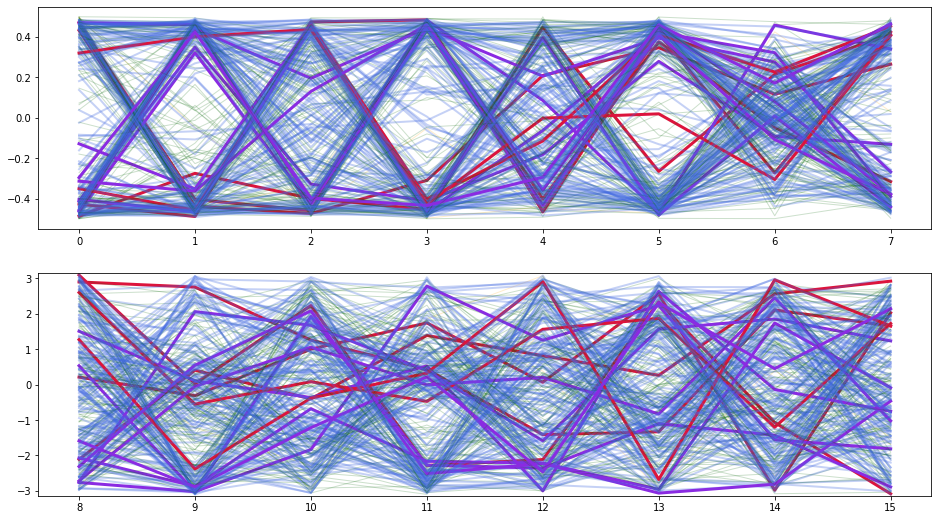

In [293]:
plt.subplots(2,figsize=FIGSIZE)
All = 0
for j in range(0, len(controller_params)):
    sols = controller_params[j]
    r = reward[j]
    color, alpha, lw = rewardToColor(r)
    if All:
        plt.subplot(211)
        for i in range(len(sols)):
            plt.plot(sols[i][:8], alpha=0.2, color=colors[0])
        plt.subplot(212)
        for i in range(len(sols)):
            plt.plot(sols[i][8:], alpha=0.2, color=colors[0])
    else:
        sols = np.mean(sols, axis=0)
        plt.subplot(211)
        plt.plot(sols[:8], alpha=alpha, lw=lw, color=color)
        plt.subplot(212)
        plt.plot(sols[8:], alpha=alpha, lw=lw, color=color)
plt.xticks(range(8),[str(i) for i in range(8, 16)])
plt.ylim((-np.pi,np.pi))